In [2]:
from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd
import os
from sklearn.neighbors import KNeighborsRegressor

In [3]:

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

def butter_bandpass_filter( data, lowcut, highcut, fs, order=5):
        # print(f'lowcut: {lowcut}, highcut: {highcut}, fs: {fs}, order: {order}')
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = filtfilt(b, a, data)
        return y
# Pre-proccessing
# Denoising 
def denoise_data( df, col_names, n_clusters):
    df_denoised = df.copy()
    df_denoised.reset_index(drop=True, inplace=True)
    for col_name, k in zip(col_names, n_clusters):
        # print(f"Processing column {col_name}")
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

# Z_scoring
def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

# Detrending
def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = detrend(df_new, col_names)
    return df_new    

In [3]:
os.getcwd()

'c:\\Users\\tnlab\\OneDrive\\Documents\\GitHub\\AlphaFold\\Neurofeedback-Based-BCI'

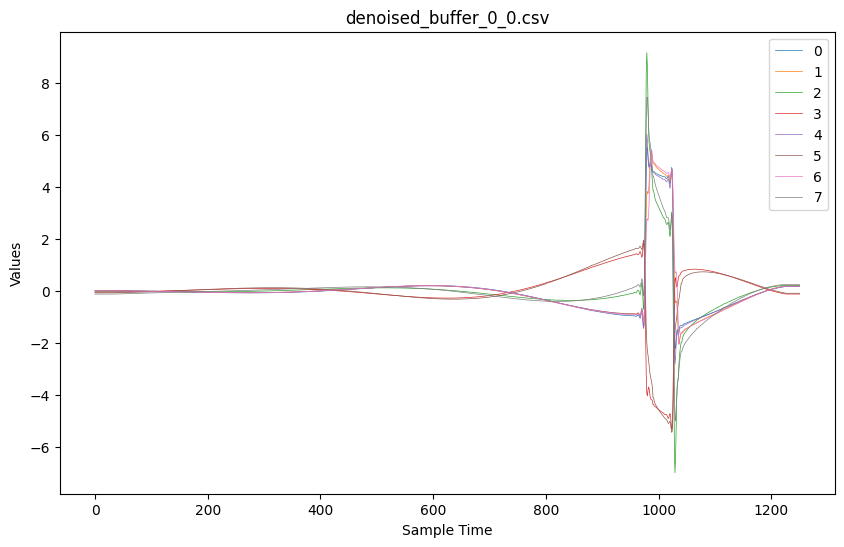

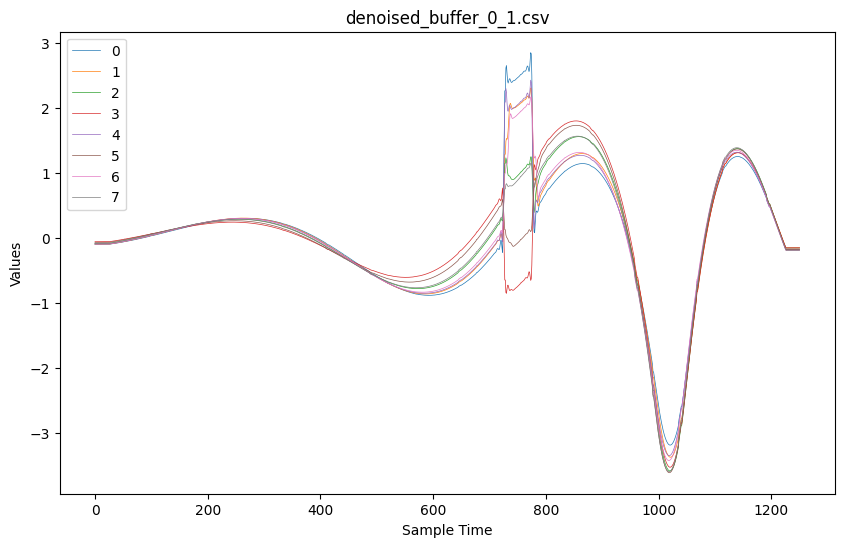

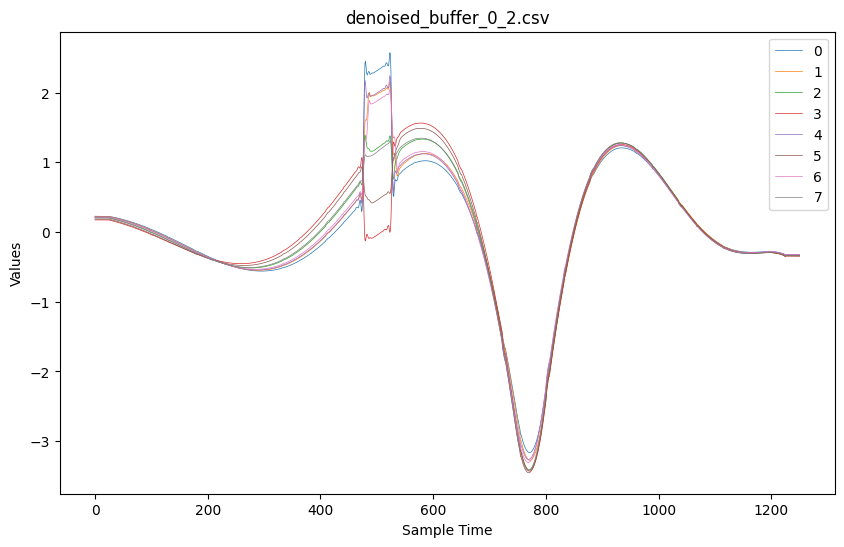

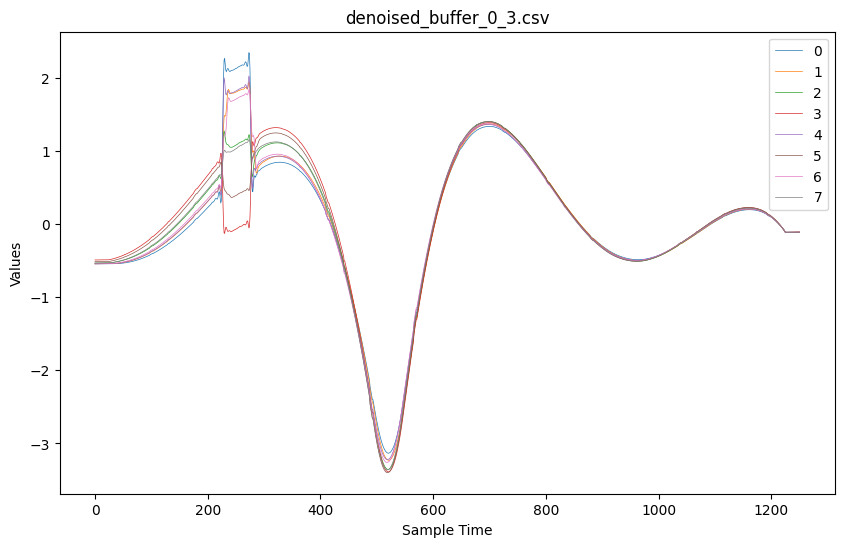

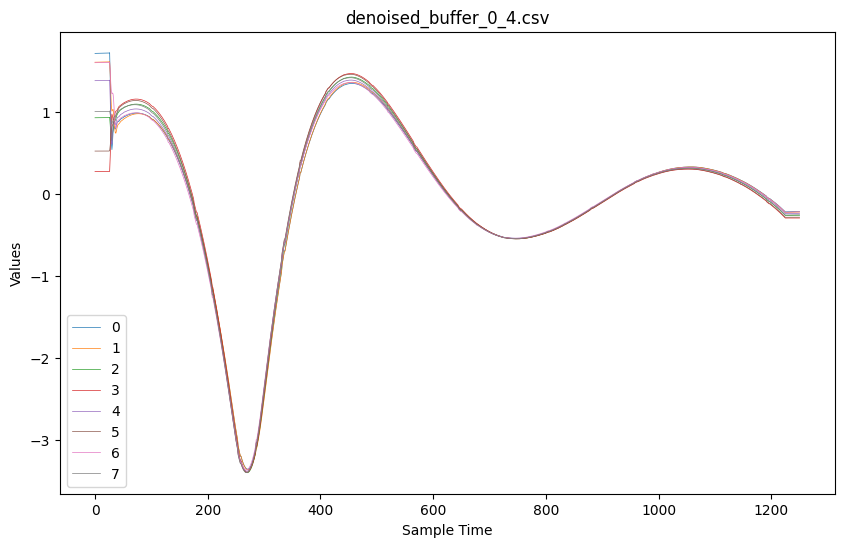

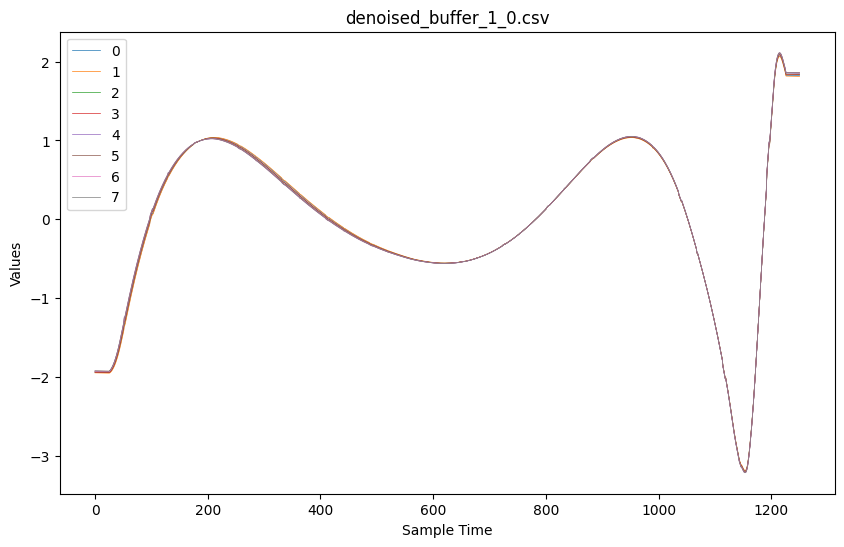

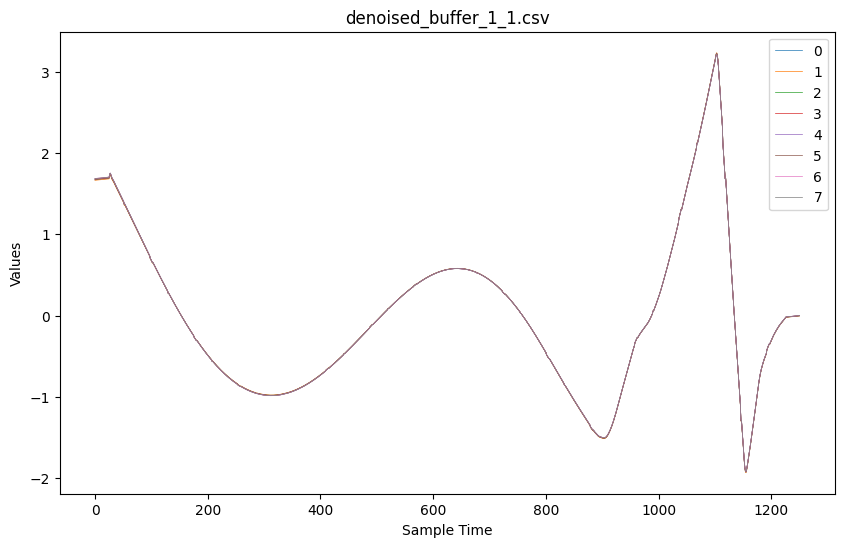

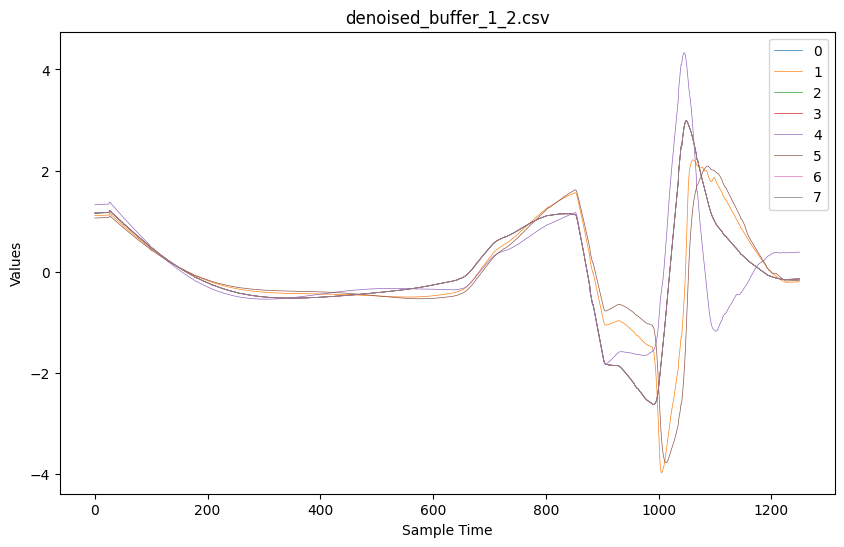

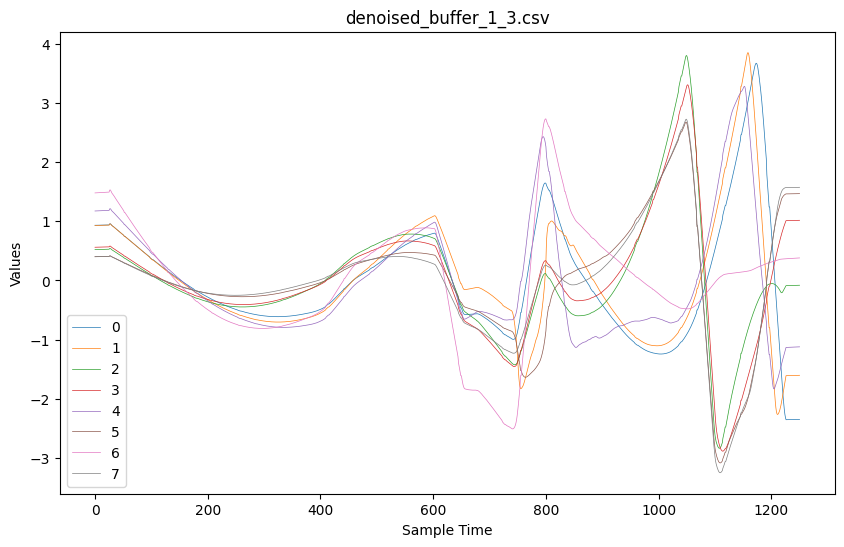

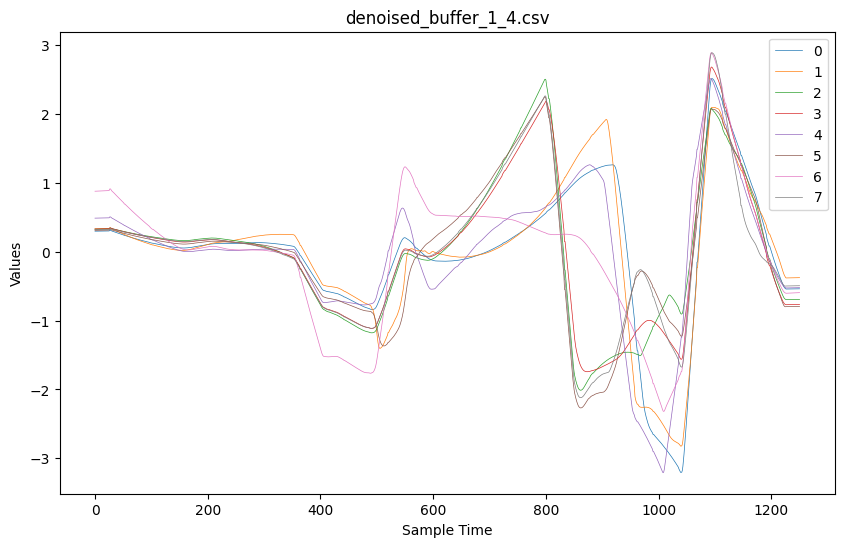

In [4]:
import matplotlib.pyplot as plt
folder_name='e'
columns=['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']

if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            # print(s_temp.shape) # (10000, 8)
            #preprocess
            raw_eeg_bp = np.copy(s_temp)
            for column in range(s_temp.shape[1]):
                raw_eeg_bp[:, column] = butter_bandpass_filter(raw_eeg_bp[:, column], lowcut=.4, highcut=40, fs=250, order=5) 
            raw_eeg_bp=pd.DataFrame(raw_eeg_bp)
            # bandpass.append(raw_eeg_bp) 
            
            eeg_df_denoised = preprocess(raw_eeg_bp, col_names=list(raw_eeg_bp.columns), n_clusters=[50]*len(raw_eeg_bp.columns))    
            # denoised.append(eeg_df_denoised)
            
            bufferdataframe=pd.DataFrame(s_temp)
            # combined_raw_eeg_nf_bp=pd.DataFrame(raw_eeg_bp)
            eeg_df_denoised_nf=pd.DataFrame(eeg_df_denoised)
            
            # plt.figure(figsize=(10, 6))  # Adjust the size as necessary
            # for col in bufferdataframe.columns:
            #     plt.plot(bufferdataframe[col], label=col, linewidth=0.5)

            #     plt.xlabel('Sample Time')
            #     plt.ylabel('Values')
            #     plt.title(f'buffer_{file_name}')
            #     plt.legend()
                    
            # plt.figure(figsize=(10, 6)) 
            # for col in  raw_eeg_bp.columns:
            #     plt.plot(raw_eeg_bp[col], label=col, linewidth=0.5)
            #     plt.xlabel('Sample Time')
            #     plt.ylabel('Values')
            #     plt.title(f'bp_{file_name}')
            #     plt.legend()

            plt.figure(figsize=(10, 6)) 
            for col in eeg_df_denoised_nf.columns: 
                plt.plot(eeg_df_denoised_nf[col], label=col, linewidth=0.5)
                plt.xlabel('Sample Time')
                plt.ylabel('Values')
                plt.title(f'denoised_{file_name}')
                plt.legend()